In [1]:
import cv2
import os
import io
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix ,classification_report

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:


labels = ['glioma', 'meningioma', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.


image_size = 150


for label in labels:
    trainPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        #image = image[50:450,50:450]
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.

print(x_train.shape)


100%|██████████| 1457/1457 [00:13<00:00, 106.09it/s]


(4117, 150, 150, 3)


In [3]:
print("x_train shape : ",x_train.shape )
y_train = np.array(y_train)
print("y_train shape : ",y_train.shape )

x_train shape :  (4117, 150, 150, 3)
y_train shape :  (4117,)


In [4]:
pd.Series(y_train).value_counts()

2    1457
1    1339
0    1321
dtype: int64

0


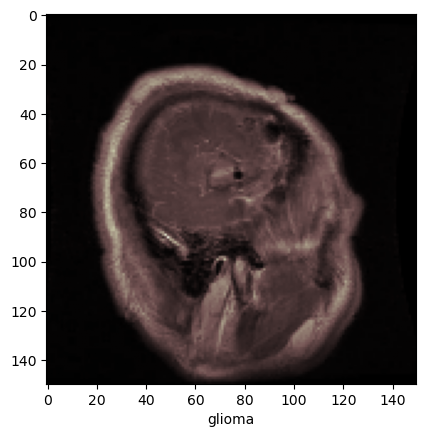

In [5]:
def plot_img(X,y,index):
    plt.imshow(X[index])
    plt.xlabel(labels[y[index]])
    print(y[index])

plot_img(x_train,y_train,0)

In [6]:


labels = ['glioma', 'meningioma', 'pituitary']

x_test = [] # training images.
y_test  = [] # training labels.


image_size = 150


for label in labels:
    testPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0) # load images in gray.
        #image = image[50:450,50:450]
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_test.append(image)
        y_test.append(labels.index(label))
    
    


x_test = np.array(x_test) / 255.0 # normalize Images into range 0 to 1.


print(x_test.shape)
y_test =np.array(y_test)

100%|██████████| 300/300 [00:02<00:00, 100.28it/s]


(906, 150, 150, 3)


In [7]:
x_train, y_train = shuffle(x_train,y_train, random_state=0)
y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(824, 150, 150, 3)


In [8]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16 , VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Apply data augmentation to the training data
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                             zoom_range=0.2, horizontal_flip=True)

datagen.fit(x_train)

In [10]:
img_width, img_height = 150,150

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
# Freeze the base model's layers
#for layer in base_model_vgg16.layers:
 #   layer.trainable = False

In [12]:
### Create a new model
model = Sequential()
model.add(base_model_vgg16)
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Add the provided layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         589952    
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                        

In [30]:
# Set up early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20,
                    validation_data=(x_val, y_val))

Epoch 1/20
103/103 [==============================] - 53s 336ms/step - loss: 0.6680 - accuracy: 0.7136 - val_loss: 0.3082 - val_accuracy: 0.8774
Epoch 2/20
103/103 [==============================] - 25s 244ms/step - loss: 0.2784 - accuracy: 0.8992 - val_loss: 0.2671 - val_accuracy: 0.8968
Epoch 3/20
103/103 [==============================] - 25s 239ms/step - loss: 0.2160 - accuracy: 0.9217 - val_loss: 0.1848 - val_accuracy: 0.9308
Epoch 4/20
103/103 [==============================] - 26s 254ms/step - loss: 0.1702 - accuracy: 0.9365 - val_loss: 0.2273 - val_accuracy: 0.9296
Epoch 5/20
103/103 [==============================] - 25s 239ms/step - loss: 0.1326 - accuracy: 0.9551 - val_loss: 0.2749 - val_accuracy: 0.9114
Epoch 6/20
103/103 [==============================] - 25s 244ms/step - loss: 0.1253 - accuracy: 0.9578 - val_loss: 0.1270 - val_accuracy: 0.9563
Epoch 7/20
103/103 [==============================] - 25s 245ms/step - loss: 0.1028 - accuracy: 0.9623 - val_loss: 0.1191 - val_ac

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

29/29 [==============================] - 3s 104ms/step - loss: 0.0542 - accuracy: 0.9868
Test Loss: 0.05424034222960472
Test Accuracy: 0.9867549538612366


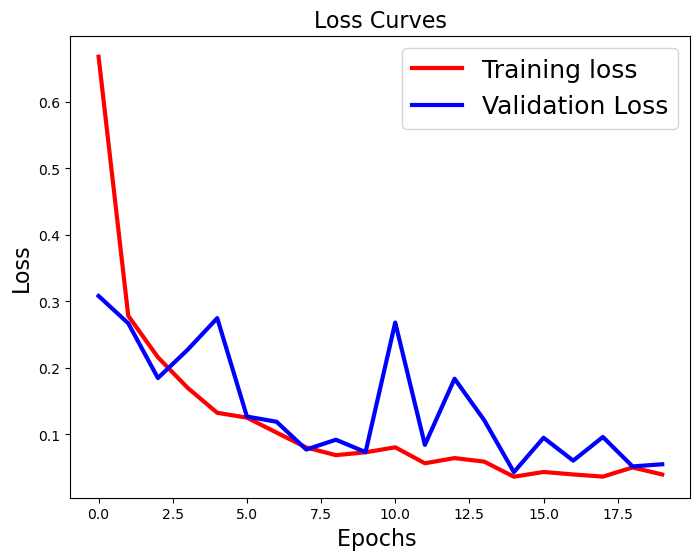

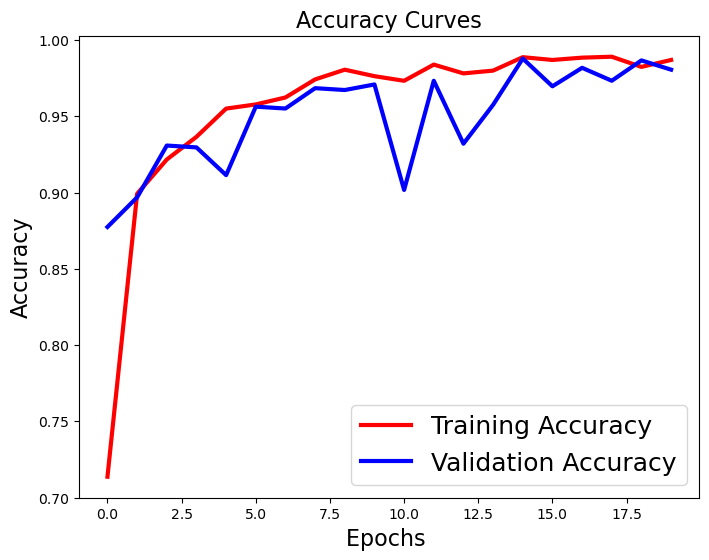

In [17]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

29/29 [==============================] - 2s 67ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       0.99      0.98      0.99       306
           2       0.98      1.00      0.99       300

    accuracy                           0.99       906
   macro avg       0.99      0.99      0.99       906
weighted avg       0.99      0.99      0.99       906



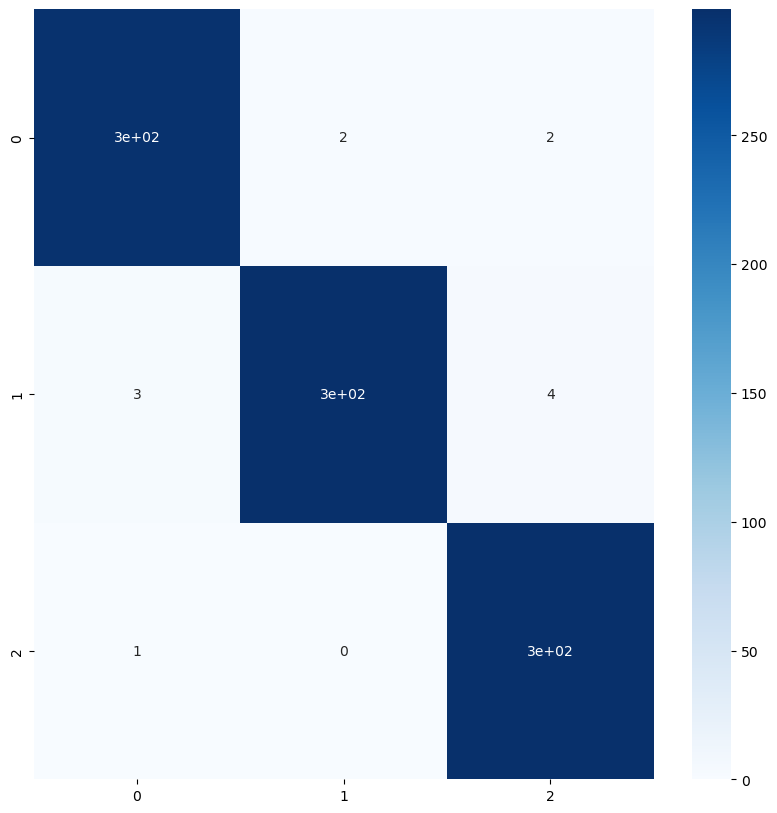

In [18]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))